Adam Ten Hoeve, Jared Pino, Joseph Plata  
COMP 4431 - Data Mining  
Assignment 7

In [1]:
# Load the required packages
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split
import statsmodels.api as sma
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from pandas_profiling import ProfileReport
import statsmodels.api as st
import sklearn.metrics as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

For this assignment, we're going to take a look at the California and Boston Housing datasets from SKLearn. Eventually, we want to create the best linear model for each dataset, in order to best predict the median cost of a home in each area. But we have a ways to get there.

Let's start by loading in each dataset and doing so preemptory exploratoy analysis.

In [2]:
# Load the two datasets from SKLearn dataset libraries
boston_data = load_boston()
california_data = fetch_california_housing()

In [3]:
# Create DataFrame for Boston Housing
bos_feature_names = boston_data["feature_names"]
boston_df = pd.DataFrame(boston_data["data"])
boston_df.columns = boston_data["feature_names"]
boston_df["MEDV"] = boston_data["target"]
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# Create DataFrame for California Housing
california_df = pd.DataFrame(california_data["data"])
california_df.columns = california_data["feature_names"]
california_df["MedHouseVal"] = california_data["target"]
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


It might get confusing to use both datasets at the same time, so we will do a deep analysis on each, one at a time. Let's start with the Boston Housing dataset. We want to get a better understanding of how the data is arranged, and whether there are any abnormal/missing values.

One very useful tool for this is a package called Pandas Profiling. It will tell us quite a bit of information about each of our variables, as well as their correlations.

In [5]:
print(boston_data["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
boston_profile = ProfileReport(boston_df)
boston_profile

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,14
Number of observations,506
Total Missing (%),0.0%
Total size in memory,55.5 KiB
Average record size in memory,112.3 B
Numeric,12
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


In [7]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


What do we see? 
* There aren't any missing values, which means we don't have to do anything too compilacated in terms of data cleaning. This is also confirmed by the dataset's description.
* The `MEDV` value has a ceiling of 50. When the data was recorded, any values that where above 50 where set to 50. This could affect our linear model, but there are not too many values (only 16 out of 506), so it shouldn't be too impactful.
* Our target variable `MEDV` appears approximately normal, with a heavy right tail. Normality of the response is one of the assumptions for linear regression, so it's good to get a sense of that now.
* `LSTAT` and `RM` have the largest correlation with `MEDV`, so we should keep an eye out for those variables in our model. We also saw that `TAX` and `RAD` where highly correlated, so we won't have to worry about keeping both in our model.
* Some of our other features like `CRIM`, `ZN` and `B` are very skewed to a single value. This likely means that those features will not be very useful for our model.

Let's take a look at the pairplots for each variable, which should give us an idea of the relationships between the features and the response. This could be especially important if they relationships aren't linear.

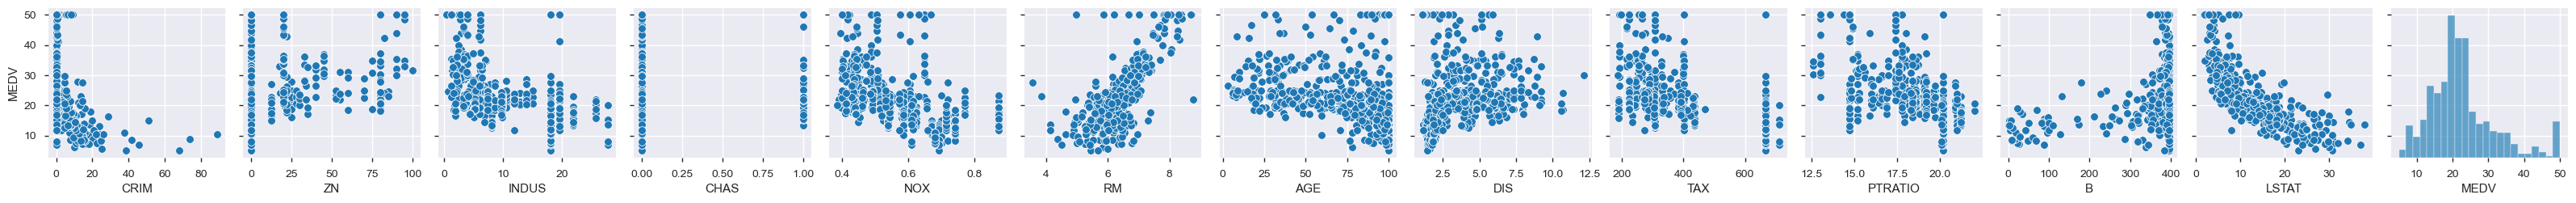

In [8]:
# Pairplots, without RAD because of high correlation
sns.pairplot(boston_df.drop(["RAD"], axis=1), y_vars=["MEDV"])

It's a bit hard to tell, but the most obvious relationships with `MEDV` are with the `RM` and `LSTAT` variables, which agrees with the correlations of these variables. Other variables that have a less-prevalent relationship include `CRIM`, `INDUS`, `NOX`, and `B`. Many of these values appear to have nonlinear relationships, so we may want to do some transformations on the data to get a trend that is closer to linear.

Let's take a look at some transformations of these variables, to try and get a better trend. We will look at the logarithm, square root and squared relationships, to get a full understanding. We do have to be a bit careful with transformations, as it will make interpreting our models more difficult.

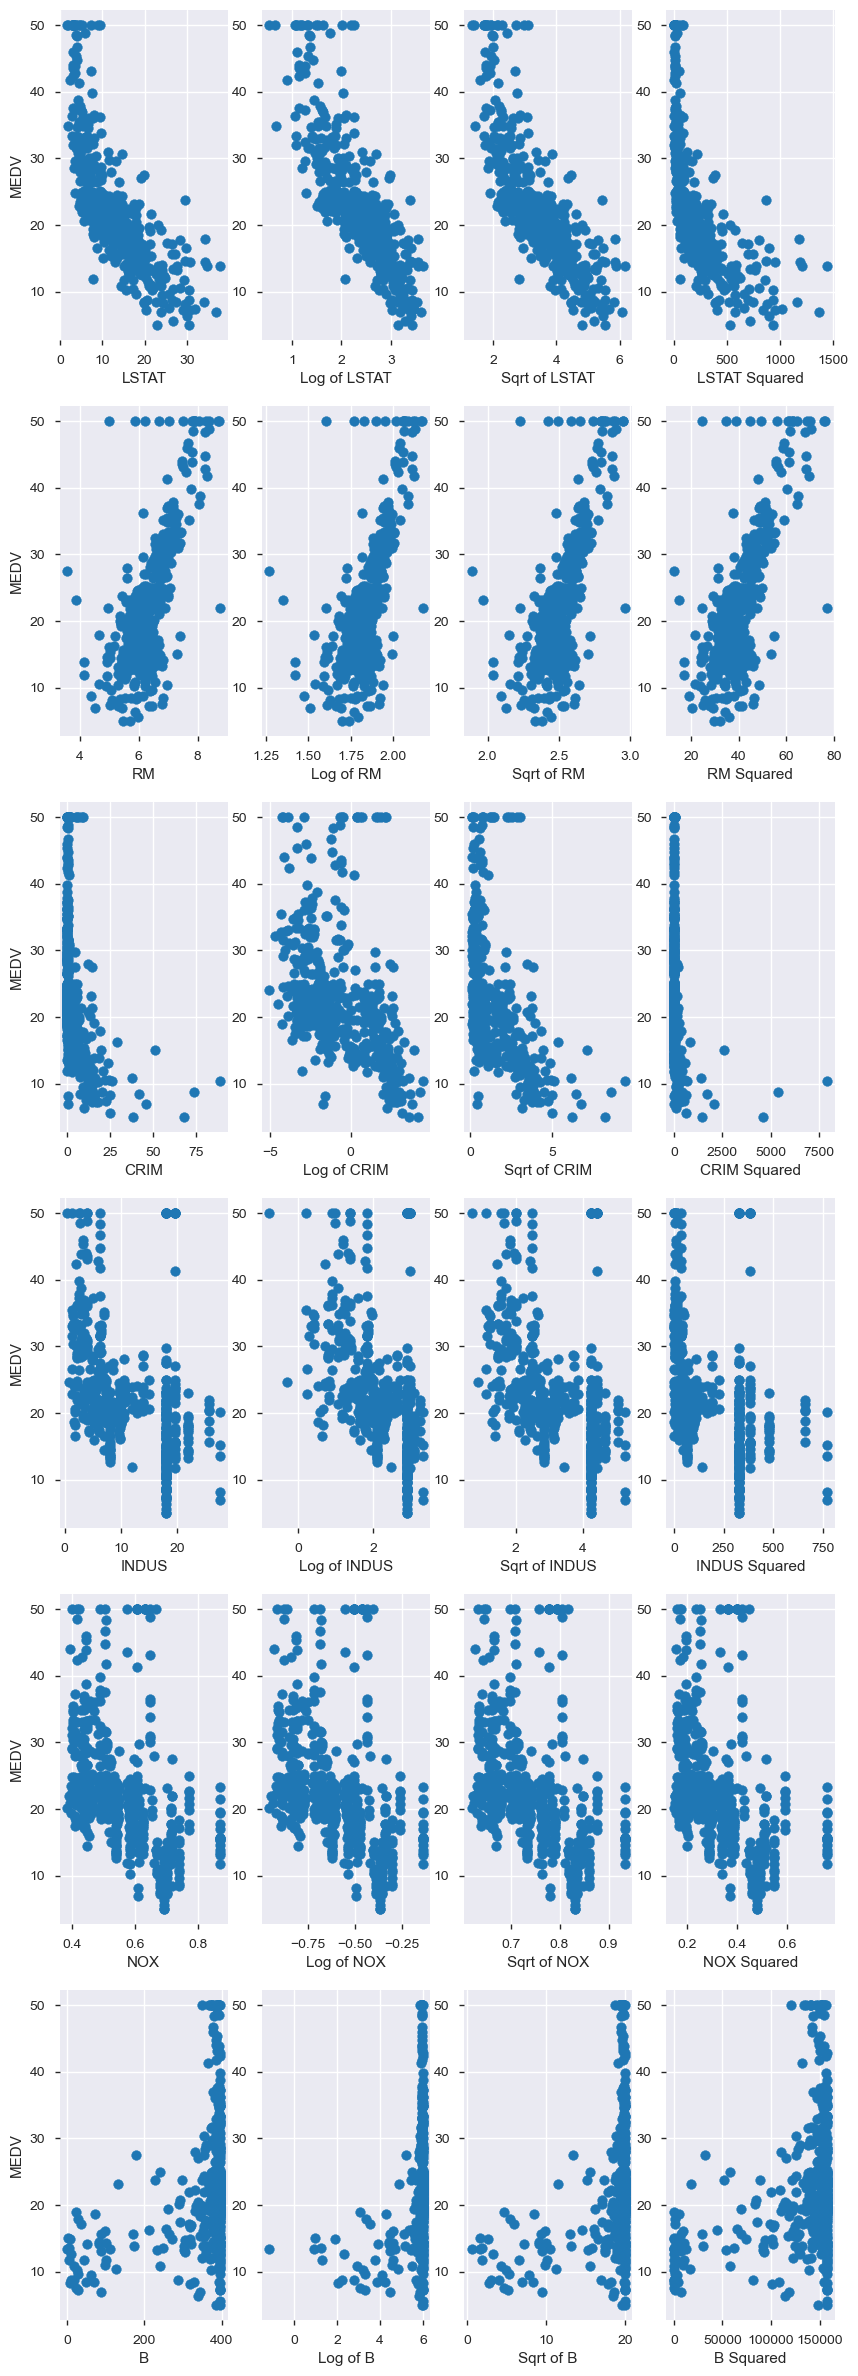

In [9]:
fig, ax = plt.subplots(6, 4, figsize=[10, 30])
# define a function to plot the transformations
def plot_transforms(axis, df, xvar, ax_index):
    axis[ax_index][0].scatter(x=df[xvar], y=df["MEDV"])
    axis[ax_index][0].set_xlabel("{}".format(xvar))
    axis[ax_index][0].set_ylabel("MEDV")
    
    axis[ax_index][1].scatter(x=np.log(df[xvar]), y=df["MEDV"])
    axis[ax_index][1].set_xlabel("Log of {}".format(xvar))

    axis[ax_index][2].scatter(x=np.sqrt(df[xvar]), y=df["MEDV"])
    axis[ax_index][2].set_xlabel("Sqrt of {}".format(xvar))

    axis[ax_index][3].scatter(x=df[xvar]**2, y=df["MEDV"])
    axis[ax_index][3].set_xlabel("{} Squared".format(xvar))
    
plot_transforms(ax, boston_df, "LSTAT", 0)
plot_transforms(ax, boston_df, "RM", 1)
plot_transforms(ax, boston_df, "CRIM", 2)
plot_transforms(ax, boston_df, "INDUS", 3)
plot_transforms(ax, boston_df, "NOX", 4)
plot_transforms(ax, boston_df, "B", 5)

Some of those transformations provide a better relationship than the untransformed data. In particular, the logarithms of `LSTAT` and `CRIM` appear more linear than the original relationship. At this point, we can fit some MLR models to our data and observe how they perform. In particular, we will fit:
* A model fit to all the data, with transformations.
* A reduced model, fit to only significant predictors. This should make interpretation easier.

Let's start by fitting a model to all the data.

In [10]:
# Split into predictors and target variables
X = boston_df.drop(["RAD"], axis=1)
# Add transformed data
X["logLSTAT"] = np.log(X["LSTAT"])
X["logCRIM"] = np.log(X["CRIM"])

# Fit a linear regression model to the data
model_full = ols("MEDV ~ CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+TAX+PTRATIO+B+LSTAT+logCRIM+logLSTAT", data=X).fit()
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     136.6
Date:                Sat, 22 May 2021   Prob (F-statistic):          4.14e-159
Time:                        10:34:30   Log-Likelihood:                -1438.5
No. Observations:                 506   AIC:                             2907.
Df Residuals:                     491   BIC:                             2970.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.4282      4.941     11.825      0.000      48.720      68.137
CRIM          -0.1648      0.031     -5.247      0.000      -0.226      -0.103
ZN             0.0226      0.013      1.731      0.084      -0.003       0.048
INDUS         -0.0654      0.053     -1.245      0.214      -0.169       0.038
CHAS           2.2824      0.764      2.986      0.003       0.781       3.784
NOX          -18.5306      3.559     -5.207      0.000     -25.524     -11.538
RM             2.6506      0.385      6.882      0.000       1.894       3.407
AGE            0.0167      0.012      1.396      0.163      -0.007       0.040
DIS           -1.1864      0.179     -6.619      0.000      -1.539      -0.834
TAX           -0.0027      0.002     -1.113      0.266      -0.007       0.002
PTRATIO       -0.7320      0.115     -6.392      0.000      -0.957      -0.507
B              0.0085      0.002      3.544      0.000       0.004       0.013
LSTAT          0.3103      0.087      3.568      0.000       0.139       0.481
logCRIM        0.9352      0.233      4.020      0.000       0.478       1.392
logLSTAT     -12.5025      1.092    -11.449      0.000     -14.648     -10.357
==============================================================================
Omnibus:                      159.558   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              862.736
Skew:                           1.271   Prob(JB):                    4.56e-188
Kurtosis:                       8.870   Cond. No.                     1.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
model_full.mse_total

84.58672359409856

From our model, we get an $R^2$ value of $0.729$ and a MSE of $84.59$. For our model selection later, we should note that this model has a BIC of $2970$. We can also see that `INDUS`, `AGE` and `TAX` are insignificant, so it's likely that we can make our model simpler. This also makes sense from our initial exploration of the trends between the predictos and the response.

We can do some model selection to make our model simpler. Going through the process of backward selection, and using BIC as our criterion, we get to the final "optimal" model shown below.

In [13]:
# Fit a linear regression model to a smaller set of predictors
model_red = ols("MEDV ~ CRIM+CHAS+NOX+RM+DIS+PTRATIO+B+LSTAT+logCRIM+logLSTAT", data=X).fit()
model_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     188.8
Date:                Sat, 22 May 2021   Prob (F-statistic):          7.72e-162
Time:                        10:34:51   Log-Likelihood:                -1442.6
No. Observations:                 506   AIC:                             2907.
Df Residuals:                     495   BIC:                             2954.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.0512      4.928     11.779      0.000      48.368      67.734
CRIM          -0.1563      0.031     -5.068      0.000      -0.217      -0.096
CHAS           2.3176      0.763      3.039      0.002       0.819       3.816
NOX          -19.1239      3.336     -5.732      0.000     -25.679     -12.569
RM             2.8872      0.371      7.779      0.000       2.158       3.616
DIS           -1.0960      0.145     -7.573      0.000      -1.380      -0.812
PTRATIO       -0.8373      0.104     -8.029      0.000      -1.042      -0.632
B              0.0090      0.002      3.741      0.000       0.004       0.014
LSTAT          0.3418      0.085      4.041      0.000       0.176       0.508
logCRIM        0.7236      0.195      3.710      0.000       0.340       1.107
logLSTAT     -12.6505      1.042    -12.143      0.000     -14.697     -10.604
==============================================================================
Omnibus:                      163.298   Durbin-Watson:                   1.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              896.294
Skew:                           1.300   Prob(JB):                    2.36e-195
Kurtosis:                       8.979   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
model_red.mse_total

84.58672359409856

Our reduced model has a lower $R^2$ value of $0.792$, an equal MSE, but a lower $BIC$ of $2954$. The lower BIC means the simpler model is preferable to the full model.

Let's take a look at the diagnostic plots for our reduced model. These plots will give us an idea of how well our model meets the linear regression assumptions.

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


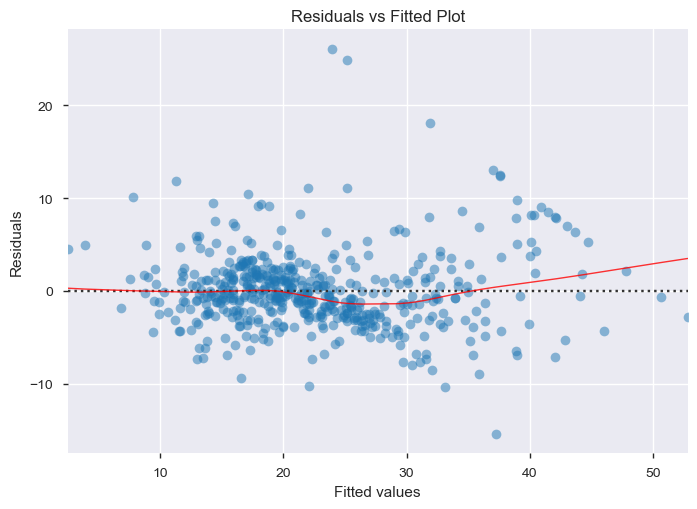

In [15]:
# Residuals vs. Fitted Values Plot

plot_model_full = plt.figure()
plot_model_full.axes[0] = sns.residplot(model_red.fittedvalues, boston_df.columns[-1], data=boston_df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_model_full.axes[0].set_title('Residuals vs Fitted Plot')
plot_model_full.axes[0].set_xlabel('Fitted values')
plot_model_full.axes[0].set_ylabel('Residuals');

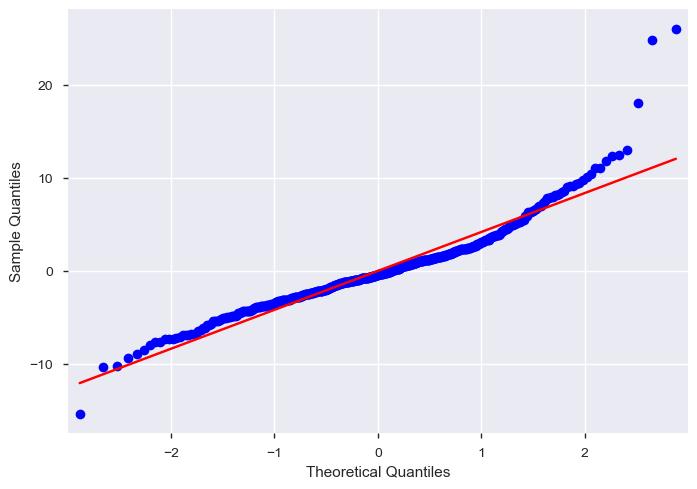

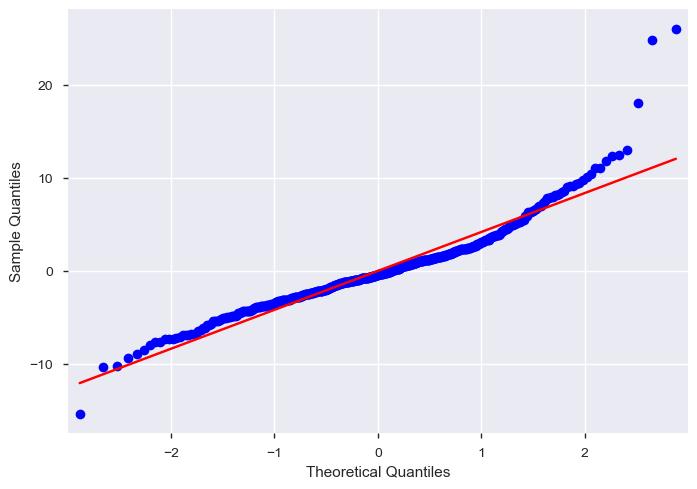

In [16]:
red_resids = model_red.resid
sma.qqplot(red_resids, line="s")

From the diagnostics plots, we can make the following conclusions:
* The linearity assumption is validated from the Residuals vs. Fitted Values plot. There is no obvious nonlinear structure to the plot, so we can infer that all the variation is in a linear structure.
* There may be some heterskedasticity. We can see that there is a high variance of some of the points in the center, with less variance around the higher values. However, the majority of the points fall in the area of constant variance.
* The normally distributed residuals assumption is (mostly) being met. The only inconsistency is a very heavy tail on the right side, which agrees with our earlier explorations.

So what? We just went through all our data and determined that **(a)** a linear model would be an appropriate fit for this data and **(b)** which features are the most important for modeling the price of a house in Boston. That means, if we know the features for another house, we should have a good idea of what price to expect for it. Nice! Now, let's take a look at the data for California houses.

Again, we're starting from nothing, so we want to do some basic exploratory analysis on the data before doing anything too severe. Let's start by making a pandas profile for the dataframe.

In [17]:
california_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
MedInc         20640 non-null float64
HouseAge       20640 non-null float64
AveRooms       20640 non-null float64
AveBedrms      20640 non-null float64
Population     20640 non-null float64
AveOccup       20640 non-null float64
Latitude       20640 non-null float64
Longitude      20640 non-null float64
MedHouseVal    20640 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB


In [18]:
cali_profile = ProfileReport(california_df)
cali_profile

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,9
Number of observations,20640
Total Missing (%),0.0%
Total size in memory,1.4 MiB
Average record size in memory,72.0 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Here's some of the main points that we can gather from the above profile:
* There are no missing values in the dataset.
* Similar to the Boston data, the target variable `MedHouseVal` has a ceiling at $5$. About $5\%$ of the data is cut off at this value. This cutoff is greater than that of the Boston dataset, so we'll see how that affects the modeling.
* The target variable `MedHouseval` is approximately normally distributed, with a long right tail. This is good for our linear regression model, but there are those ceiling values, which may be a problem.
* There is a high correlation between `MedHouseVal` and `MedInc`, meaning it's likely to be an important predictor. A scatterplot of these two features is show below. The rest of the predictors are not very correlated with the target variable.
* From the histograms, we can see that `AveRooms`, `AveBedrms` and `AveOccup` were heavily skewed, with long right tails. These extreme values may be outliers, and negatively effect our model.

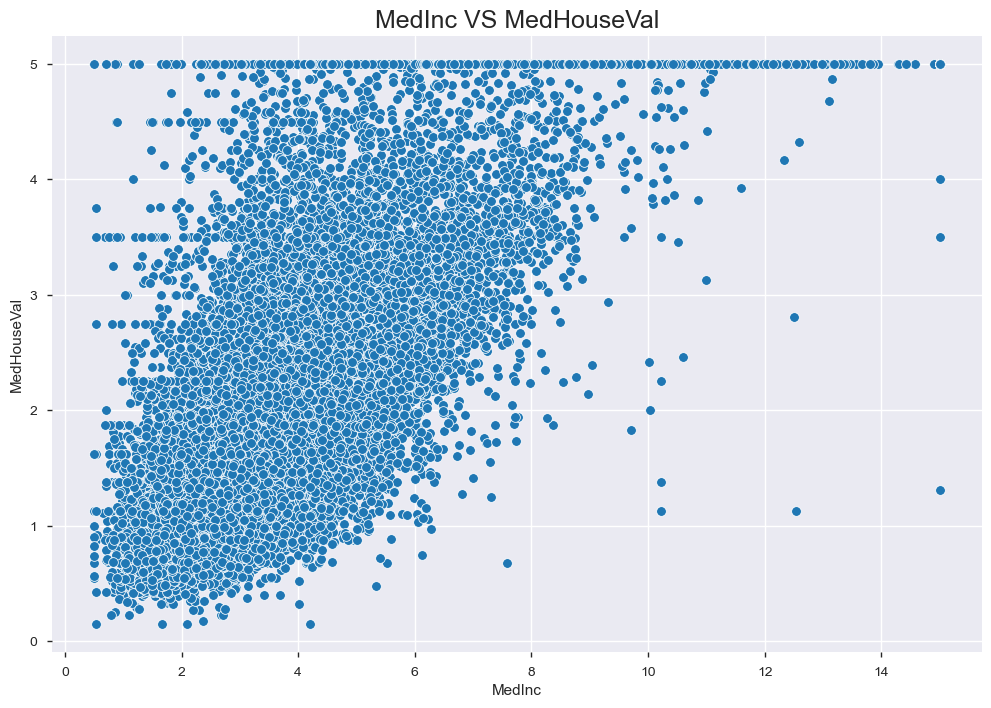

In [19]:
# Scatterplot of MedHouseVal vs MedInc
sns.scatterplot(x="MedInc", y="MedHouseVal", data=california_df)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.title("MedInc VS MedHouseVal", size=18)
plt.show()

The ceiling on `MedHouseVal` is quite pronounced in this data, so it will probably have a large effect on our model. The reason for this is that those data point betray the underlying population distribution of the rest of the data, and will confuse any model we try to fit them to. We can also see that, at least with `MedInc`, the values fall at all different values, so it's not very predictable.

One more thing we can look at is geographic data. Unlike the Boston datasest, the California dataset contains Latitude and Longitude coordinates. This means we can use these coordinates to visualize the geographic layout of the different housing prices. Let's take a look at that.

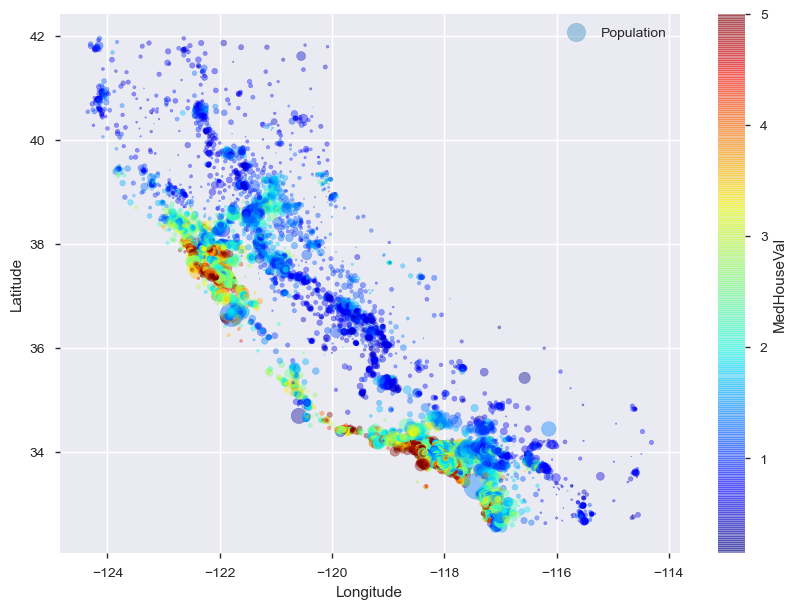

In [20]:
california_df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
             s=california_df["Population"]/100, label="Population", figsize=(10,7),
             c="MedHouseVal", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend();

From the geographic plot, we can see that areas that fall along the coast and in large population centers are generally higher priced than the other areas. If we where to do some extensive feature engineering, labelling these areas or even the city each is located in, it would likely be beneficial to our final model.

Let's take a look at the relationships between the features and the target variable.

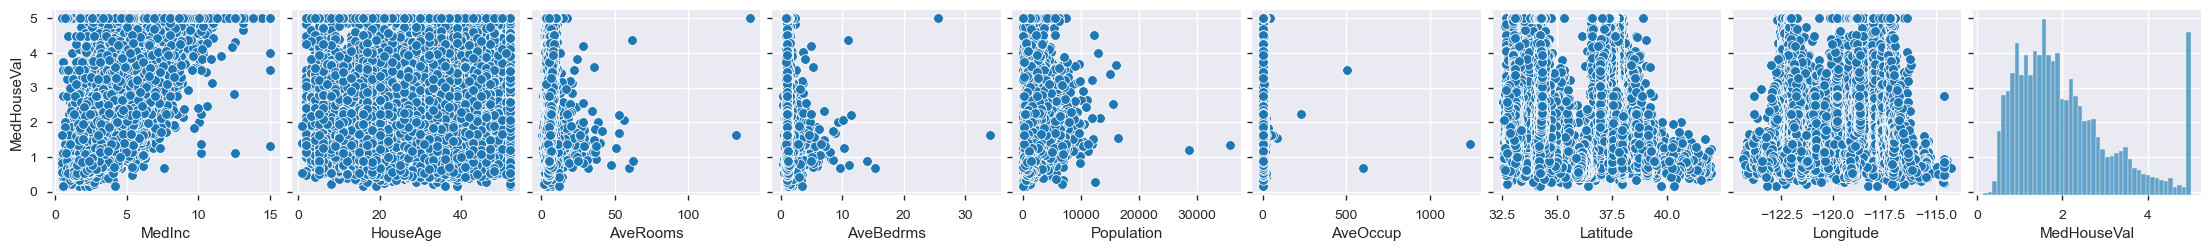

In [21]:
# Pairplots between target and 
sns.pairplot(california_df, y_vars=["MedHouseVal"])

None of the features have an obvious relationship between the two variables, besides potentially `MedInc`. This should mean our model won't fit the variance of the data very well. There also isn't any obvious transformations for the data to make it more managable.

Let's fit our model to the full dataset and see how it does.

In [22]:
formula = "MedHouseVal ~ MedInc+HouseAge+AveRooms+AveBedrms+Population+AveOccup+Latitude+Longitude"

model_cali = ols(formula, data=california_df).fit()
model_cali.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        10:35:07   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.9419      0.659    -56.067      0.000     -38.233     -35.650
MedInc         0.4367      0.004    104.054      0.000       0.428       0.445
HouseAge       0.0094      0.000     21.143      0.000       0.009       0.010
AveRooms      -0.1073      0.006    -18.235      0.000      -0.119      -0.096
AveBedrms      0.6451      0.028     22.928      0.000       0.590       0.700
Population -3.976e-06   4.75e-06     -0.837      0.402   -1.33e-05    5.33e-06
AveOccup      -0.0038      0.000     -7.769      0.000      -0.005      -0.003
Latitude      -0.4213      0.007    -58.541      0.000      -0.435      -0.407
Longitude     -0.4345      0.008    -57.682      0.000      -0.449      -0.420
==============================================================================
Omnibus:                     4393.650   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14087.596
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                       6.420   Cond. No.                     2.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
model_cali.mse_total

1.3316148163035277

Our california model had an $R^2$ value of $0.606$ and an MSE of $1.332$. This looks okay, but we might be able to do better. Let's take a look at the diagnostic plots.

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals')

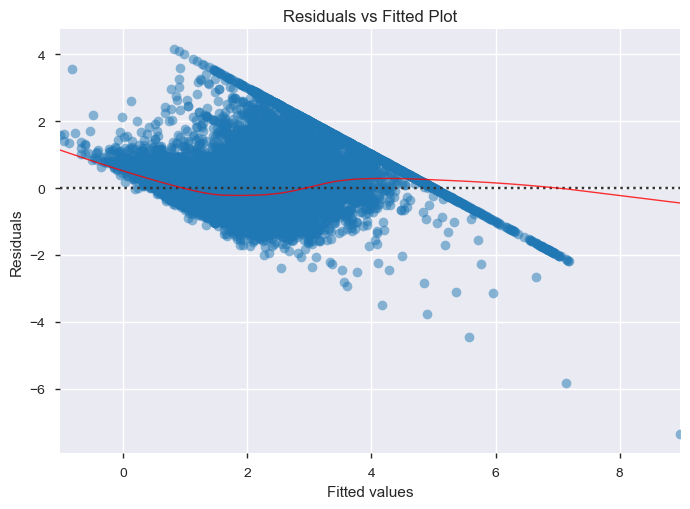

In [24]:
# Residuals vs. Fitted Values Plot
plot_model_cali = plt.figure()
plot_model_cali.axes[0] = sns.residplot(model_cali.fittedvalues, 
                                        california_df.columns[-1], 
                                        data=california_df,
                                        lowess=True,
                                        scatter_kws={'alpha': 0.5},
                                        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_model_cali.axes[0].set_title('Residuals vs Fitted Plot')
plot_model_cali.axes[0].set_xlabel('Fitted values')
plot_model_cali.axes[0].set_ylabel('Residuals')

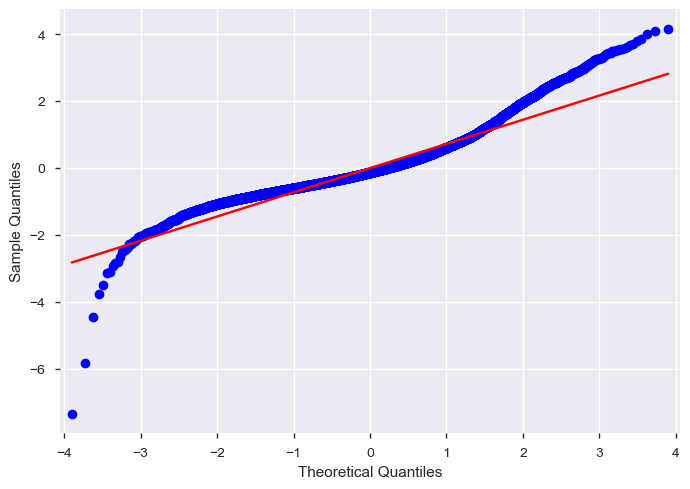

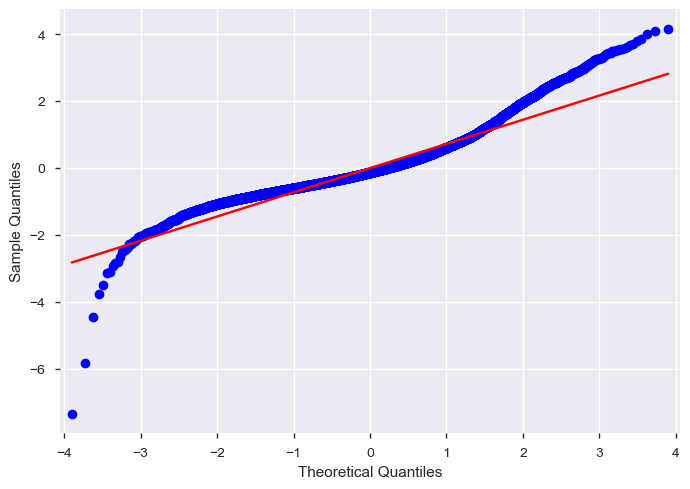

In [25]:
# QQPlot of california model
cali_resids = model_cali.resid
sma.qqplot(cali_resids, line="s")

The diagnostic plots don't look too good. The QQPlot is okay, but it has some pretty heavy tails on both sides. The Residuals vs. Fitted values plot shows the hard cutoff line, that is likely the `MedHouseVal` ceiling that we note earlier. These are both strong indiciations that our linear model isn't working too well.

How would we go about fixing this? One idea is to remove the datapoints that are capped at `MedHouseVal = 5`. These values don't follow the same underlying distribution as the rest of the data, so it doesn't make a lot of sense to try to predict them as well. By removing them, we could get a better model.

We should note that removing data is usually discouraged, but in this case, it may allow our model to actually fit to the underlying trends, rather than being affected by outliers. But we can try it, and if it doesn't work, then no harm done.

In [36]:
print(california_data["DESCR"])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [26]:
# Create a dataframe of california data without the ceiling MedHouseVal=5 data
cali_df_small = california_df.loc[california_df["MedHouseVal"] < 5]
# Recreate the profile on the new, smaller dataset
cali_profile_small = ProfileReport(cali_df_small)
cali_profile_small

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,10
Number of observations,19648
Total Missing (%),0.0%
Total size in memory,1.5 MiB
Average record size in memory,80.0 B
Numeric,10
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


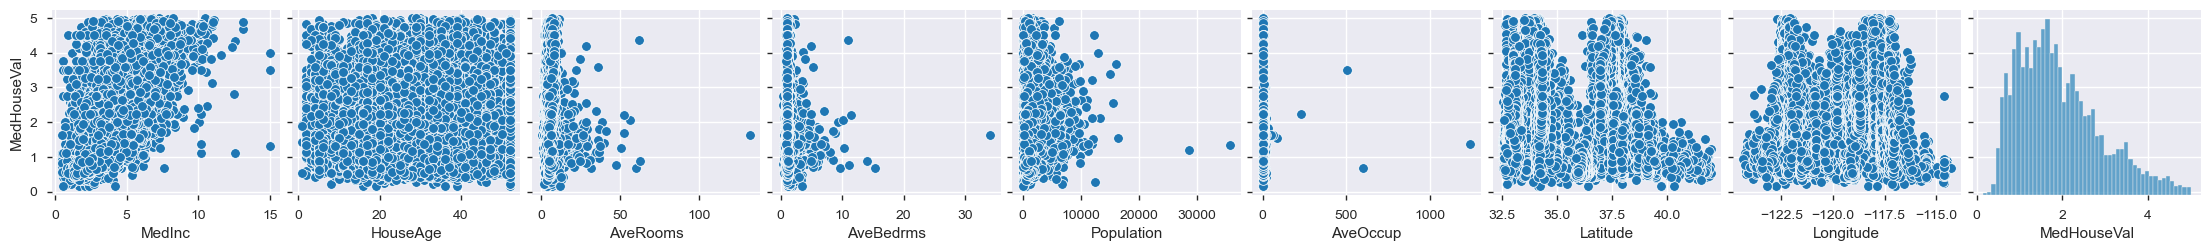

In [27]:
# Recreate the pairplots for the target variable
sns.pairplot(cali_df_small, y_vars=["MedHouseVal"])

What's different with the reduced dataset, compared to the full dataset?
* There is no longer a large amount of outliers at `MedHouseVal=5`. This is shown in the histogram, which resembles the normal distribution much more closely than the original dataset.
* Most of the features look very similar, and generally did not change much after the removal of the extra data. The heavily skewed features (`AveRooms`, `AveBedrms`, `AveOccup`) are still heavily skewed.
* The correlations between the predictors and the target variables are also about the same as they where in the original model.

Let's fit our linear regression and see how our model does.

In [28]:
# Fit a linear regression to the reduced data
model_cali_small = ols(formula, data=cali_df_small).fit()
model_cali_small.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     3312.
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        10:41:49   Log-Likelihood:                -18913.
No. Observations:               19648   AIC:                         3.784e+04
Df Residuals:                   19639   BIC:                         3.792e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -33.5544      0.595    -56.352      0.000     -34.722     -32.387
MedInc         0.4307      0.005     93.636      0.000       0.422       0.440
HouseAge       0.0081      0.000     19.711      0.000       0.007       0.009
AveRooms      -0.1081      0.006    -19.120      0.000      -0.119      -0.097
AveBedrms      0.6018      0.026     23.085      0.000       0.551       0.653
Population  5.324e-06   4.22e-06      1.262      0.207   -2.95e-06    1.36e-05
AveOccup      -0.0034      0.000     -8.003      0.000      -0.004      -0.003
Latitude      -0.3772      0.007    -57.869      0.000      -0.390      -0.364
Longitude     -0.3934      0.007    -57.650      0.000      -0.407      -0.380
==============================================================================
Omnibus:                     3455.761   Durbin-Watson:                   0.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10185.770
Skew:                           0.925   Prob(JB):                         0.00
Kurtosis:                       6.003   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# MSE of reduced model
model_cali_small.mse_total

0.9430518158422286

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals')

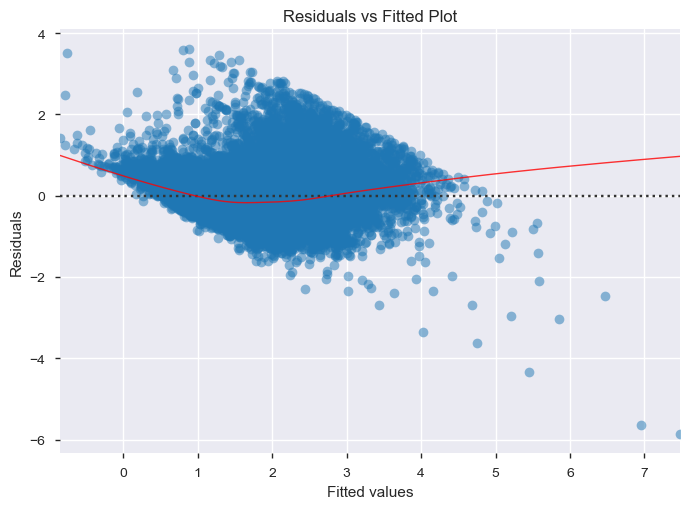

In [29]:
# Diagnostic plots
# Residuals vs. Fitted Values Plot
plot_model_cali_small = plt.figure()
plot_model_cali_small.axes[0] = sns.residplot(model_cali_small.fittedvalues, 
                                              cali_df_small.columns[-1], 
                                              data=cali_df_small,
                                              lowess=True,
                                              scatter_kws={'alpha': 0.5},
                                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_model_cali_small.axes[0].set_title('Residuals vs Fitted Plot')
plot_model_cali_small.axes[0].set_xlabel('Fitted values')
plot_model_cali_small.axes[0].set_ylabel('Residuals')

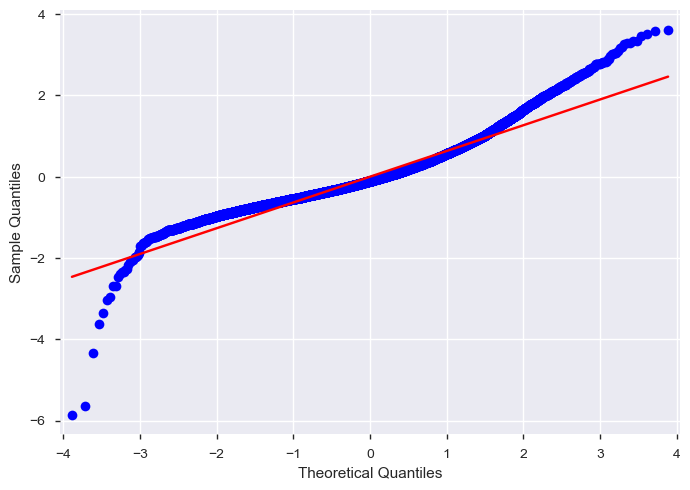

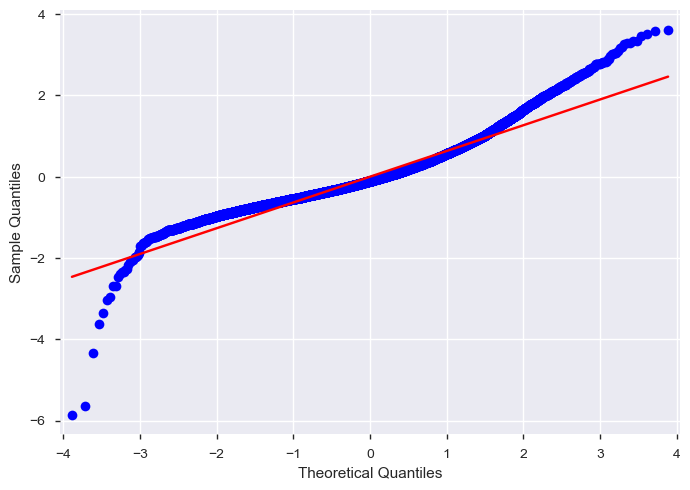

In [30]:
# QQPlot of reduced california model
cali_small_resids = model_cali_small.resid
sma.qqplot(cali_small_resids, line="s")

The Residuals vs. Fitted Values plot has fewer values on the rightmost edge, but there is still a definate diagonal structure. This likely means that the data is ordered in some way, or that the observations are not independent. The QQplot is also very similar to our original. The smaller model had a worse $R^2$ value of $0.574$, but a smaller MSE of $0.943$. Overall, we can probably assert that the smaller model was not significantly better than the full model, so we shouldn't remove those ceiling datapoints.

What does this mean overall? A linear model may not be suitable for the California housing dataset, as there was obvious structure in the diagnostics plots and other linear model assumptions where being violated. We would need to do more work before being sure that our model was producing accurate results.

## Conclusions

Overall, we analyzed the two datasets and determined that a linear model would be suitable for the Boston Housing dataset, but less suitable for the California housing dataset. We do have two different linear models, which could be used to predict the median price of houses in the two areas, but the predictive power of those models could be improved.